In [1]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.synchronize()

In [1]:
import torch
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
from src.datasets.fbirn_main import load_data as load_fbirn_main
from src.datasets.fbirn_holdout import load_data as load_fbirn_holdout
from src.datasets.fbirn_main_sex import load_data as load_fbirn_main_sex
from src.datasets.fbirn_holdout_sex import load_data as load_fbirn_holdout_sex
from src.datasets.fbirn_roi import load_data as load_fbirn_sch

# old model

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

Logs_Root = "/data/users2/ppopov1/glass_proj/assets/test_logs/old_model/"

class RegCEloss:
    """Cross-entropy loss with model regularization"""

    def __init__(self, model_cfg):
        self.sparsity_loss = InvertedHoyerMeasure(threshold=model_cfg.loss.threshold)

        self.sp_weight = model_cfg.loss.sp_weight
        self.pred_weight = model_cfg.loss.pred_weight


    def __call__(self, logits, target, FNCs, predicted, originals):
        if logits is not None and target is not None: # training case
            ce_loss = F.cross_entropy(logits, target)

            B, T, C, _ = FNCs.shape
            FNCs = FNCs.reshape(B*T, C, C)
            sparse_loss = self.sparsity_loss(FNCs)

            pred_loss = F.mse_loss(predicted, originals)

            loss = ce_loss + self.sp_weight * sparse_loss + self.pred_weight * pred_loss

            loss_components = {
                "ce_loss": ce_loss.item(),
                "sp_loss": sparse_loss.item(),
                "pred_loss": pred_loss.item(),
            }
            return loss, loss_components
        
        else: # pretraining case
            B, T, C, _ = FNCs.shape
            FNCs = FNCs.reshape(B*T, C, C)
            sparse_loss = self.sparsity_loss(FNCs)

            pred_loss = F.mse_loss(predicted, originals)

            loss =  self.sp_weight * sparse_loss + self.pred_weight * pred_loss

            loss_components = {
                "sp_loss": sparse_loss.item(),
                "pred_loss": pred_loss.item(),
            }
            return loss, loss_components

class InvertedHoyerMeasure:
    """Sparsity loss function based on Hoyer measure: https://jmlr.csail.mit.edu/papers/volume5/hoyer04a/hoyer04a.pdf"""
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, x):
        # Assuming x has shape (batch_size, input_dim, input_dim)

        n = x[0].numel()
        sqrt_n = torch.sqrt(torch.tensor(float(n), device=x.device))
        sum_abs_x = torch.sum(torch.abs(x), dim=(1, 2))
        sqrt_sum_squares = torch.sqrt(torch.sum(torch.square(x), dim=(1, 2)))

        numerator = sqrt_n - sum_abs_x / sqrt_sum_squares
        denominator = sqrt_n - 1
        mod_hoyer = 1 - (numerator / denominator) # = 0 if perfectly sparse, 1 if all are equal

        loss = F.leaky_relu(mod_hoyer - self.threshold)
        # Calculate the mean loss over the batch
        mean_loss = torch.mean(loss)

        return mean_loss

class glassDBN(nn.Module):
    def __init__(self, model_cfg):
        super(glassDBN, self).__init__()

        self.input_size = input_size = model_cfg.input_size # n_components (#ROIs/ICs)
        self.num_layers = num_layers = model_cfg.rnn.num_layers # GRU n_layers; won't work with values other than 1
        self.embedding_dim = embedding_dim = model_cfg.rnn.input_embedding_size # embedding size for GRU input
        self.hidden_dim = hidden_dim = model_cfg.rnn.hidden_size # GRU hidden dim
        output_size = model_cfg.output_size # n_classes to predict
        self.single_embed = model_cfg.rnn.single_embed # whether all time series should be embedded with the same vector or not
        
        # Component-specific embeddings
        if model_cfg.rnn.single_embed:
            self.embeddings = nn.Linear(1, embedding_dim)
        else:
            self.embeddings = nn.ModuleList([
                nn.Linear(1, embedding_dim) for _ in range(input_size)
            ])

        # GRU layer
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)

        # Attention layer used to compute the transfer matrices
        self.attention = SelfAttention(
            input_dim=hidden_dim, 
            hidden_dim=model_cfg.attention.hidden_dim,
            n_components=self.input_size
        )

        # Classifier
        self.clf = nn.Sequential(
            nn.Linear(input_size**2, input_size**2 // 2),
            nn.ReLU(),
            nn.Dropout1d(p=0.3),
            nn.Linear(input_size**2 // 2, input_size**2 // 4),
            nn.ReLU(),
            nn.Linear(input_size**2 // 4, output_size),
        )
        # Input predictor
        self.predictor = nn.Linear(hidden_dim, 1)

        self.criterion = RegCEloss(model_cfg)

    def compute_loss(self, additional_outputs, logits, target):
        loss, log = self.criterion(
            logits=logits, 
            target=target, 
            FNCs=additional_outputs["FNCs"], 
            predicted=additional_outputs["predicted"],
            originals=additional_outputs["originals"]
        )

        return loss, log

    
    def save_data(self, cfg, ds_name, data, target, additional_outputs):
        save_path = f"{cfg.run_dir}/data"
        os.makedirs(save_path, exist_ok=True)
        torch.save(data, f"{save_path}/{ds_name}_input.pt")
        torch.save(target, f"{save_path}/{ds_name}_labels.pt")
        torch.save(additional_outputs["FNCs"], f"{save_path}/{ds_name}_FNCs.pt")
        torch.save(additional_outputs["time_logits"], f"{save_path}/{ds_name}_time_logits.pt")

    def forward(self, x, pretraining=False):
        B, T, _ = x.shape  # [batch_size, time_length, input_size]
        orig_x = x

        # Apply component-specific embeddings
        if self.single_embed:
            x = x.permute(0, 2, 1)
            x = x.reshape(B * self.input_size, T, 1)
            embedded = self.embeddings(x).reshape(B, self.input_size, T, self.embedding_dim)
        else:
            embedded = torch.stack([self.embeddings[i](x[:, :, i].unsqueeze(-1)) for i in range(self.input_size)], dim=1)
        # embedded shape: [batch_size, input_size, time_length, embedding_dim]
        
        # Initialize hidden state and run the recurren loop
        h = torch.zeros(B, 1, self.input_size, self.hidden_dim, device=x.device)
        # hidden state shape: [batch_size, 1, input_size, hidden_dim]

        mixing_matrices = []
        hidden_states = []
        for t in range(T):
            # Process one time step
            gru_input = embedded[:, :, t, :].unsqueeze(2)  # (batch_size, input_size, 1, embedding_dim)
            gru_input = gru_input.reshape(B*self.input_size, 1, self.embedding_dim) # (batch_size * input_size, 1, embedding_dim)
            h = h.permute(1, 0, 2, 3).reshape(1, B*self.input_size, self.hidden_dim) # (1, batch_size * input_size, hidden_dim)
            _, h = self.gru(gru_input, h)
            h = h.reshape(1, B, self.input_size, self.hidden_dim).permute(1, 0, 2, 3) # (batch_size, 1, input_size, hidden_dim)

            # Reshape h for self-attention
            h = h.squeeze(1)  # (batch_size, input_size, hidden_dim)
            # Apply self-attention
            h, mixing_matrix = self.attention(h)
            hidden_states.append(h)
            mixing_matrices.append(mixing_matrix)
            h = h.unsqueeze(1) # (batch_size, 1, input_size, hidden_dim)

            if torch.any(torch.isnan(h)):
                raise Exception(f"h has nans at time point {t}")
            
        
        # Stack the alignment matrices, predict the next input 
        mixing_matrices = torch.stack(mixing_matrices, dim=1)  # (batch_size, seq_len, input_size, input_size)
        hidden_states = torch.stack(hidden_states, dim=1)[:, :-1, :, :] # brain latent states starting with time 0, [batch_size; time_length-1; input_size, hidden_dim]
        predicted = self.predictor(hidden_states).squeeze() # predictions of x starting with time 1, [batch_size; time_length-1; input_size]
        
        if pretraining:
            # pretrain on the input prediction task
            return {
                "FNCs": mixing_matrices,
                "predicted": predicted,
                "originals": orig_x[:, 1:, :]
            }
        
        clf_input = mixing_matrices.reshape(B, T, -1) # [batch_size; time_length; input_size * input_size]
        time_logits = self.clf(clf_input) # [batch_size; time_length, n_classes]
        logits = torch.mean(time_logits, dim=1) # mean over time, [batch_size; n_classes]
        
        additional_outputs = {
            "FNCs": mixing_matrices,
            "time_logits": time_logits,
            "predicted": predicted,
            "originals": orig_x[:, 1:, :]
        }

        return logits, additional_outputs



class SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_components):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim

        self.gate = Gate(n_components)

        self.query = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.key = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )


    def forward(self, x): # x.shape (batch_size, n_components, GRU hidden size)
        queries = self.query(x)
        keys = self.key(x)

        transfer = torch.bmm(queries, keys.transpose(1, 2))
        norms = torch.linalg.matrix_norm(transfer, keepdim=True)
        transfer = transfer / norms

        gate = self.gate(transfer)
        transfer = transfer * gate

        next_states = torch.bmm(transfer, x)

        return next_states, transfer

class Gate(nn.Module):
    def __init__(self, input_dim):
        super(Gate, self).__init__()
        self.bias = nn.Parameter(torch.randn(input_dim, input_dim))
    
    def forward(self, x):
        # Compute h_ij = abs(x_ij) + b_ij
        h = torch.abs(x) + self.bias
        
        # Compute a_ij = sigmoid(h_ij)
        a = torch.sigmoid(h)
        
        return a


In [4]:
from omegaconf import OmegaConf

model_cfg = OmegaConf.create({
    "rnn": {
        "single_embed": True,
        "num_layers": 1,
        "input_embedding_size": 16,
        "hidden_size": 16,
    },
    "attention": {
        "hidden_dim": 16,
    },
    "loss": {
        "threshold": 0.01,
        "sp_weight": 1.0,
        "pred_weight": 1.0,
    },
    "lr": 1e-4,
    "load_pretrained": False,
    "pretrained_path": None,
    "input_size": 53,
    "output_size": 2,
})


In [5]:
model = glassDBN(model_cfg).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {count_parameters(model)}")
print(f"Embedding layer parameters: {count_parameters(model.embeddings)}")
print(f"GRU layer parameters: {count_parameters(model.gru)}")
print(f"Attention layer parameters: {count_parameters(model.attention)}")
print(f"Classifier parameters: {count_parameters(model.clf)}")
print(f"Predictor parameters: {count_parameters(model.predictor)}")

Total parameters: 4939078
Embedding layer parameters: 32
GRU layer parameters: 1632
Attention layer parameters: 4441
Classifier parameters: 4932956
Predictor parameters: 17


# model rewrite

In [12]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from omegaconf import OmegaConf

Logs_Root = "/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/"

class InvertedHoyerMeasure:
    """Sparsity loss function based on Hoyer measure: https://jmlr.csail.mit.edu/papers/volume5/hoyer04a/hoyer04a.pdf"""
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, x):
        # Assuming x has shape (batch_size, input_dim, input_dim)

        n = x[0].numel()
        sqrt_n = torch.sqrt(torch.tensor(float(n), device=x.device))
        sum_abs_x = torch.sum(torch.abs(x), dim=(1, 2))
        sqrt_sum_squares = torch.sqrt(torch.sum(torch.square(x), dim=(1, 2)))

        numerator = sqrt_n - sum_abs_x / sqrt_sum_squares
        denominator = sqrt_n - 1
        mod_hoyer = 1 - (numerator / denominator) # = 0 if perfectly sparse, 1 if all are equal

        loss = F.leaky_relu(mod_hoyer - self.threshold)
        # Calculate the mean loss over the batch
        mean_loss = torch.mean(loss)

        return mean_loss

# ## for tests
# loss = InvertedHoyerMeasure(0.1)
# arr = torch.ones(4, 10, 20)
# print(loss(arr)) # should be 0.9 = perfectly dense + threshold

# arr = torch.zeros(4, 10, 20)
# arr[:, 1 , 1] = 1
# print(loss(arr)) # should be -0.0010 = perfectly sparse + thrshold + leakyReLU

class BDMLoss:
    """Cross-entropy, sparsity, and input prediction losses"""

    def __init__(self, model_cfg):
        self.sparsity_loss = InvertedHoyerMeasure(threshold=model_cfg.loss.threshold)

        self.sp_weight = model_cfg.loss.sp_weight
        self.pred_weight = model_cfg.loss.pred_weight


    def __call__(self, logits, target, FNCs, predicted, originals):
        if logits is not None and target is not None: # training case
            ce_loss = F.cross_entropy(logits, target)
            loss = ce_loss
            ce_loss = ce_loss.item()

            if self.sp_weight is not None:
                B, T, C, _ = FNCs.shape
                FNCs = FNCs.reshape(B*T, C, C)
                sparse_loss = self.sparsity_loss(FNCs)
                loss += self.sp_weight * sparse_loss
                sparse_loss = sparse_loss.item()
            else:
                sparse_loss = 0

            if self.pred_weight is not None:
                pred_loss = F.mse_loss(predicted, originals)
                loss += self.pred_weight * pred_loss
                pred_loss = pred_loss.item()
            else:
                pred_loss = 0

            loss_components = {
                "ce_loss": ce_loss,
                "sp_loss": sparse_loss,
                "pred_loss": pred_loss,
            }
            return loss, loss_components
        
        else: # pretraining case
            assert self.pred_weight is not None

            pred_loss = F.mse_loss(predicted, originals)
            loss = self.pred_weight * pred_loss
            pred_loss = pred_loss.item()

            if self.sp_weight is not None:
                B, T, C, _ = FNCs.shape
                FNCs = FNCs.reshape(B*T, C, C)
                sparse_loss = self.sparsity_loss(FNCs)
                loss += self.sp_weight * sparse_loss
                sparse_loss = sparse_loss.item()
            else:
                sparse_loss = 0

            loss_components = {
                "sp_loss": sparse_loss,
                "pred_loss": pred_loss,
            }
            return loss, loss_components



class BrainDynaMo(nn.Module):
    def __init__(self, model_cfg):
        super(BrainDynaMo, self).__init__()

        self.input_size = input_size = model_cfg.input_size # n_components (#ROIs/ICs)
        self.embedding_dim = embedding_dim = model_cfg.rnn.input_embedding_size # embedding size for GRU input
        self.hidden_dim = hidden_dim = model_cfg.rnn.hidden_size # GRU hidden dim
        output_size = model_cfg.output_size # n_classes to predict


        # input embedding vector and GRU block
        self.embeddings = nn.Linear(1, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        # Attention layer used to compute the matrices that mix the GRU hidden states
        self.attention = BilinearAttention(
            input_dim=hidden_dim, 
            hidden_dim=model_cfg.attention.hidden_dim,
            n_components=self.input_size
        )

        # Classifier
        self.clf = nn.Sequential(
            nn.Linear(input_size**2, 32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        )
        # Input predictor
        self.predictor = nn.Linear(hidden_dim, 1)

        self.criterion = BDMLoss(model_cfg)

    def compute_loss(self, additional_outputs, logits=None, target=None):
        loss, log = self.criterion(
            logits=logits, 
            target=target, 
            FNCs=additional_outputs["FNCs"], 
            predicted=additional_outputs["predicted"],
            originals=additional_outputs["originals"]
        )

        return loss, log

    def save_data(self, cfg, ds_name, data, target, additional_outputs):
        save_path = f"{cfg.run_dir}/data"
        os.makedirs(save_path, exist_ok=True)
        torch.save(data, f"{save_path}/{ds_name}_input.pt")
        torch.save(target, f"{save_path}/{ds_name}_labels.pt")
        torch.save(additional_outputs["FNCs"], f"{save_path}/{ds_name}_FNCs.pt")
        torch.save(additional_outputs["time_logits"], f"{save_path}/{ds_name}_time_logits.pt")

    def forward(self, x, pretraining=False):
        B, T, C = x.shape  # [batch_size, time_length, input_size]; self.input_size == C
        orig_x = x

        # Apply embedding vector
        x = x.permute(0, 2, 1)
        x = x.reshape(B, C, T, 1)
        embedded = self.embeddings(x) # shape: (B, C, T, self.embedding_dim)

        # Initialize hidden state and run the recurrent loop
        h = torch.zeros(B, C, self.hidden_dim, device=x.device)
        # hidden state shape: [B, C, self.hidden_dim]

        mixing_matrices = []
        hidden_states = []
        for t in range(T):
            # prepare the input data for GRU
            gru_input = embedded[:, :, t, :].unsqueeze(2)  # (B, C, 1, embedding_dim)
            gru_input = gru_input.reshape(B*C, 1, self.embedding_dim) # (B*C, 1, embedding_dim)
            # input hidden state must have shape (D * num_layers, N, hidden_size), D*num_layers = 1 in our case, N is GRU batch size
            h = h.reshape(1, B*C, self.hidden_dim) # (1, B*C, hidden_dim)

            # update the hidden states with the new input by running GRU
            _, h = self.gru(gru_input, h) # output h shape is the same: (1, GRU_batch, hidden_size)
            h = h.reshape(B, self.input_size, self.hidden_dim) # (B, C, hidden_dim)

            # Apply self-attention
            h, mixing_matrix = self.attention(h)
            hidden_states.append(h)
            mixing_matrices.append(mixing_matrix)

            if torch.any(torch.isnan(h)):
                raise Exception(f"h has nans at time point {t}")


        # Stack the alignment matrices, predict the next input 
        mixing_matrices = torch.stack(mixing_matrices, dim=1)  # (batch_size, seq_len, input_size, input_size)
        hidden_states = torch.stack(hidden_states, dim=1)[:, :-1, :, :] # brain latent states starting with time 0, [batch_size; time_length-1; input_size, hidden_dim]
        predicted = self.predictor(hidden_states).squeeze() # predictions of x starting with time 1, [batch_size; time_length-1; input_size]

        if pretraining:
            # pretrain on the input prediction task
            return None, {
                "FNCs": mixing_matrices,
                "predicted": predicted,
                "originals": orig_x[:, 1:, :]
            }
        
        clf_input = mixing_matrices.reshape(B, T, -1) # [batch_size; time_length; input_size * input_size]
        time_logits = self.clf(clf_input) # [batch_size; time_length, n_classes]
        logits = torch.mean(time_logits, dim=1) # mean over time, [batch_size; n_classes]

        additional_outputs = {
            "FNCs": mixing_matrices,
            "time_logits": time_logits,
            "predicted": predicted,
            "originals": orig_x[:, 1:, :]
        }

        return logits, additional_outputs


class BilinearAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_components):
        super(BilinearAttention, self).__init__()
        self.input_dim = input_dim

        self.gate = Gate(n_components)

        self.query = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.key = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
        )


    def forward(self, x): # x.shape (batch_size, n_components, GRU hidden size)
        queries = self.query(x)
        keys = self.key(x)

        transfer = torch.bmm(queries, keys.transpose(1, 2))
        norms = torch.linalg.matrix_norm(transfer, keepdim=True)
        transfer = transfer / norms

        gate = self.gate(transfer)
        transfer = transfer * gate

        next_states = torch.bmm(transfer, x)

        return next_states, transfer

class Gate(nn.Module):
    def __init__(self, input_dim):
        super(Gate, self).__init__()
        self.bias = nn.Parameter(torch.randn(input_dim, input_dim))

    def forward(self, x):
        h = torch.abs(x) + self.bias

        a = torch.sigmoid(h)

        return a


default_model_cfg = OmegaConf.create({
    "rnn": {
        "input_embedding_size": 64,
        "hidden_size": 64,
    },
    "attention": {
        "hidden_dim": 64,
    },
    "loss": {
        "threshold": 0.01,
        "sp_weight": 1.0,
        "pred_weight": 1.0,
    },
    "lr": 2e-4,
    "load_pretrained": False,
    "pretrained_path": None,
    "input_size": 53,
    "output_size": 2,
})

model_cfg = default_model_cfg

In [4]:
model = BrainDynaMo(model_cfg).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {count_parameters(model)}")
print(f"Embedding layer parameters: {count_parameters(model.embeddings)}")
print(f"GRU layer parameters: {count_parameters(model.gru)}")
print(f"Attention layer parameters: {count_parameters(model.attention)}")
print(f"Classifier parameters: {count_parameters(model.clf)}")
print(f"Predictor parameters: {count_parameters(model.predictor)}")

Total parameters: 142908
Embedding layer parameters: 128
GRU layer parameters: 24960
Attention layer parameters: 27769
Classifier parameters: 89986
Predictor parameters: 65


# expiremental setup

In [13]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold

def prepare_dataloaders(data, labels, k, hold_data=None, hold_labels=None, n_splits=5, batch_size=64):
    if hold_data is not None and hold_labels is not None:
        hold_data = torch.tensor(hold_data, dtype=torch.float32).to(device)
        hold_labels = torch.tensor(hold_labels, dtype=torch.int64).to(device)

    data = torch.tensor(data, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    splits = list(skf.split(data, labels))
    train_idx, test_idx = splits[k]

    train_data, train_labels = data[train_idx], labels[train_idx]
    test_data, test_labels = data[test_idx], labels[test_idx]

    val_split = int(len(train_data) * 0.8)
    train_data, val_data = train_data[:val_split], train_data[val_split:]
    train_labels, val_labels = train_labels[:val_split], train_labels[val_split:]

    dataloaders = {}
    dataloaders["train"] = DataLoader(
        TensorDataset(train_data, train_labels),
        batch_size=batch_size,
        num_workers=0,
        shuffle=True,
    )
    dataloaders["valid"] = DataLoader(
        TensorDataset(val_data, val_labels),
        batch_size=batch_size,
        num_workers=0,
        shuffle=False,
    )
    dataloaders["test"] = DataLoader(
        TensorDataset(test_data, test_labels),
        batch_size=batch_size,
        num_workers=0,
        shuffle=False,
    )
    if hold_data is not None and hold_labels is not None:
        dataloaders["hold"] = DataLoader(
            TensorDataset(hold_data, hold_labels),
            batch_size=batch_size,
            num_workers=0,
            shuffle=False,
        )

    if hold_data is not None and hold_labels is not None:
        return dataloaders, hold_data, hold_labels
    else:
        return dataloaders

In [20]:
import torch
from tqdm import tqdm
import math
from sklearn.metrics import roc_auc_score
import numpy as np

def run_epoch(model, dataloaders, dataloader_name, optimizer=None, pretraining=False):
    """
    Run an epoch on the given dataloader_name.
    Performs gradient updates if the dataloader is for training.
    """
    dataloader = dataloaders[dataloader_name]
    is_train = dataloader_name == "train"
    model.train() if is_train else model.eval()

    n_samples = len(dataloaders[dataloader_name].dataset)
    n_batches = math.ceil(n_samples / dataloaders[dataloader_name].batch_size)
    total_loss = 0
    loss_components = {}
    all_preds = []
    all_labels = []
    
    for inputs, labels in dataloader:
        # Load data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        with torch.set_grad_enabled(is_train):
            logits, additional_outputs = model(inputs, pretraining=pretraining)
            loss, loss_logs = model.compute_loss(additional_outputs, logits=logits, target=labels)

            if pretraining:
                preds = torch.cat((labels.unsqueeze(1), labels.unsqueeze(1)), dim=1)
            else:
                preds = torch.softmax(logits, dim=-1)

            all_preds.append(preds.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

            # Update metrics
            total_loss += loss.item()
            for key, value in loss_logs.items():
                loss_components[key] = loss_components.get(key, 0.0) + value
            
            # Backward pass and optimization (for training only)
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # Calculate metrics
    epoch_loss = total_loss / n_batches
    loss_components = {key: value / n_batches for key, value in loss_components.items()}
    # Calculate ROC AUC score for the entire epoch
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    roc_auc = roc_auc_score(all_labels, all_preds[:, 1])

    metrics = {
        dataloader_name + "_average_loss": epoch_loss,
        dataloader_name + "_roc_auc": roc_auc,
        **{f"{dataloader_name}_{key}": value for key, value in loss_components.items()},
    }
    return epoch_loss, metrics


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_matrices(matrices, save_path, n_samples=5, n_time=5):
    # Normalize the range for the seismic colormap to center around 0
    abs_max = matrices[:n_samples, 50:(n_time+50)].abs().max().item()
    vmin, vmax = -abs_max, abs_max  # Centering colormap around 0

    # Create the figure and axes grid
    fig, axes = plt.subplots(n_samples, n_time, figsize=(n_time * 2, n_samples * 2))
    axes = np.array(axes)

    for i in range(n_samples):
        for j in range(n_time):
            ax = axes[i, j] if n_samples > 1 and n_time > 1 else axes[max(i, j)]
            matrix = matrices[i, 50+j].cpu().detach().numpy()  # Convert to NumPy
            ax.imshow(matrix, cmap="seismic", vmin=vmin, vmax=vmax, interpolation='none')
            # ax.axis("off")  # Turn off axis labels
            ax.set_xticks([])
            ax.set_yticks([])

    # Save the canvas as a PNG
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_combined_matrices(matrices, save_path, n_samples=5, n_time=5):
    # Normalize the range for the seismic colormap to center around 0
    abs_max = matrices[:n_samples, 50:(n_time+50)].abs().max().item()
    vmin, vmax = -abs_max, abs_max  # Centering colormap around 0

    # Determine the size of individual matrices
    matrix_size = matrices[0, 0].shape[0]

    # Create a large matrix to hold all the smaller matrices with padding
    combined_matrix = np.full(
        ((matrix_size + 1) * n_samples - 1, (matrix_size + 1) * n_time - 1),
        0.1
    )

    for i in range(n_samples):
        for j in range(n_time):
            matrix = matrices[i, 50 + j].cpu().detach().numpy()  # Convert to NumPy
            start_row = i * (matrix_size + 1)
            start_col = j * (matrix_size + 1)
            combined_matrix[start_row:start_row + matrix_size, start_col:start_col + matrix_size] = matrix

    # Plot the combined matrix
    dpi=20
    figsize = combined_matrix.shape[1] / dpi, combined_matrix.shape[0] / dpi  # Match the figure size to the array dimensions (pixels)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(combined_matrix, cmap="seismic", vmin=vmin, vmax=vmax, interpolation='none')
    plt.savefig(save_path, dpi=dpi)
    plt.close()



In [16]:
import pandas as pd

def run_experiment(epochs, model, dataloaders, hold_data, optimizer, 
                   save_path=f"/data/users2/ppopov1/glass_proj/assets/test_logs/test/",
                   pretraining=False):
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    train_results = []
    val_results = []
    test_results = []
    for epoch in tqdm(range(epochs)):
        matrices = model(hold_data, pretraining=True)
        matrices = matrices[1]["FNCs"]

        # plot_matrices(matrices, f"{save_path}/matrix_{epoch}.png", n_samples=1)
        plot_combined_matrices(matrices, f"{save_path}/matrix_{epoch}.png", n_samples=1)

        train_loss, train_metrics = run_epoch(model, dataloaders, "train", optimizer, pretraining=pretraining)
        valid_loss, val_metrics = run_epoch(model, dataloaders, "valid", pretraining=pretraining)
        test_loss, test_metrics = run_epoch(model, dataloaders, "test", pretraining=pretraining)

        train_results.append(train_metrics)
        val_results.append(val_metrics)
        test_results.append(test_metrics)

    train_results = pd.DataFrame(train_results)
    val_results = pd.DataFrame(val_results)
    test_results = pd.DataFrame(test_results)

    train_results.to_csv(f"{save_path}/train_results.csv", index=False)
    val_results.to_csv(f"{save_path}/val_results.csv", index=False)
    test_results.to_csv(f"{save_path}/test_results.csv", index=False)

    return train_results, val_results, test_results

# run FBIRN SZ

In [9]:
fbirn_data, fbirn_labels = load_fbirn_main()
fbirn_hold_data, fbirn_hold_labels = load_fbirn_holdout()
dataloaders, hold_data, hold_labels = prepare_dataloaders(
    fbirn_data,
    fbirn_labels,
    k=0,
    hold_data=fbirn_hold_data,
    hold_labels=fbirn_hold_labels
)

In [27]:
# test run

from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 53

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/test/"
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

results_sz = run_experiment(4, model, dataloaders, hold_data, optimizer, save_path=savepath)

"""
to make gif:

file_list=$(for i in {0..3}; do [[ -f "_test_fbirn_sz_${i}.png" ]] && echo "_test_fbirn_sz_${i}.png"; done | sort -V)
convert -delay 20 -loop 0 $file_list _test_fbirn_sz.gif
"""


100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


'\nto make gif:\n\nfile_list=$(for i in {0..3}; do [[ -f "_test_fbirn_sz_${i}.png" ]] && echo "_test_fbirn_sz_${i}.png"; done | sort -V)\nconvert -delay 20 -loop 0 $file_list _test_fbirn_sz.gif\n'

In [10]:
# looking closer at the training

from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 53

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/fast_learning/"
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
results_fast = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath)

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/slow_learning/"
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
results_slow = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath)

"""
file_list=$(for i in {0..399}; do [[ -f "fast_learning/matrix_${i}.png" ]] && echo "fast_learning/matrix_${i}.png"; done | sort -V)
convert -delay 10 -loop 1 $file_list _fast_learning.gif

file_list=$(for i in {0..399}; do [[ -f "slow_learning/matrix_${i}.png" ]] && echo "slow_learning/matrix_${i}.png"; done | sort -V)
convert -delay 10 -loop 1 $file_list _slow_learning.gif
"""

100%|██████████| 400/400 [11:32<00:00,  1.73s/it]


In [ ]:
# trying different configurations of the loss
from omegaconf import open_dict

for i in range(10):
    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/all_losses_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_pred_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_pred_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_sp_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    no_sp_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = None
        model_cfg.loss.sp_weight = None
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/only_ce_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    only_ce_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath)

    with open_dict(model_cfg):
        model_cfg.input_size = 53
        model_cfg.loss.pred_weight = 1.0
        model_cfg.loss.sp_weight = 1.0
    savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_ce_{i}/"
    model = BrainDynaMo(model_cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
    all_losses_result = run_experiment(100, model, dataloaders, hold_data, optimizer, save_path=savepath, pretraining=True)

"""
file_list=$(for i in {0..399}; do [[ -f "all_losses/matrix_${i}.png" ]] && echo "all_losses/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 1 $file_list _all_losses.gif;

file_list=$(for i in {0..399}; do [[ -f "no_pred/matrix_${i}.png" ]] && echo "no_pred/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 1 $file_list _no_pred.gif;

file_list=$(for i in {0..399}; do [[ -f "no_sp/matrix_${i}.png" ]] && echo "no_sp/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 1 $file_list _no_sp.gif;

file_list=$(for i in {0..399}; do [[ -f "only_ce/matrix_${i}.png" ]] && echo "only_ce/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 1 $file_list _only_ce.gif;

file_list=$(for i in {0..399}; do [[ -f "no_ce/matrix_${i}.png" ]] && echo "no_ce/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 1 $file_list _no_ce.gif;
"""

 24%|██▍       | 24/100 [00:43<02:16,  1.79s/it]


KeyboardInterrupt: 

In [ ]:
for i in {1..5}; do
    file_list=$(for j in {0..399}; do [[ -f "all_losses_${i}/matrix_${j}.png" ]] && echo "all_losses_${i}/matrix_${j}.png"; done | sort -V);
    convert -delay 10 -loop 1 $file_list "_all_losses_${i}.gif";

    file_list=$(for j in {0..399}; do [[ -f "no_pred_${i}/matrix_${j}.png" ]] && echo "no_pred_${i}/matrix_${j}.png"; done | sort -V);
    convert -delay 10 -loop 1 $file_list "_no_pred_${i}.gif";

    file_list=$(for j in {0..399}; do [[ -f "no_sp_${i}/matrix_${j}.png" ]] && echo "no_sp_${i}/matrix_${j}.png"; done | sort -V);
    convert -delay 10 -loop 1 $file_list "_no_sp_${i}.gif";

    file_list=$(for j in {0..399}; do [[ -f "only_ce_${i}/matrix_${j}.png" ]] && echo "only_ce_${i}/matrix_${j}.png"; done | sort -V);
    convert -delay 10 -loop 1 $file_list "_only_ce_${i}.gif";

    file_list=$(for j in {0..399}; do [[ -f "only_pred_${i}/matrix_${j}.png" ]] && echo "only_pred_${i}/matrix_${j}.png"; done | sort -V);
    convert -delay 10 -loop 1 $file_list "_only_pred_${i}.gif";
done

In [ ]:
# checking (rerunning) weird result from the previous cell
from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 53
    model_cfg.loss.pred_weight = 1.0
    model_cfg.loss.sp_weight = 1.0
savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/all_losses_1/"
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
all_losses_result = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath)

# with open_dict(model_cfg):
#     model_cfg.input_size = 53
#     model_cfg.loss.pred_weight = None
#     model_cfg.loss.sp_weight = 1.0
# savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_pred_1/"
# model = BrainDynaMo(model_cfg).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
# no_pred_result = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath)

with open_dict(model_cfg):
    model_cfg.input_size = 53
    model_cfg.loss.pred_weight = 1.0
    model_cfg.loss.sp_weight = None
savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_sp_1/"
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
no_sp_result = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath)

# with open_dict(model_cfg):
#     model_cfg.input_size = 53
#     model_cfg.loss.pred_weight = None
#     model_cfg.loss.sp_weight = None
# savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/only_ce_1/"
# model = BrainDynaMo(model_cfg).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg.lr)
# only_ce_result = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath)

"""
file_list=$(for i in {0..399}; do [[ -f "all_losses_1/matrix_${i}.png" ]] && echo "all_losses_1/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 1 $file_list _all_losses_1.gif;

file_list=$(for i in {0..399}; do [[ -f "no_pred_1/matrix_${i}.png" ]] && echo "no_pred_1/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 1 $file_list _no_pred_1.gif;

file_list=$(for i in {0..399}; do [[ -f "no_sp_1/matrix_${i}.png" ]] && echo "no_sp_1/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 1 $file_list _no_sp_1.gif;

file_list=$(for i in {0..399}; do [[ -f "only_ce_1/matrix_${i}.png" ]] && echo "only_ce_1/matrix_${i}.png"; done | sort -V);
convert -delay 10 -loop 1 $file_list _only_ce_1.gif;

"""

100%|██████████| 400/400 [11:32<00:00,  1.73s/it]


'\nfile_list=$(for i in {0..399}; do [[ -f "all_losses_1/matrix_${i}.png" ]] && echo "all_losses_1/matrix_${i}.png"; done | sort -V);\nconvert -delay 10 -loop 1 $file_list _all_losses_1.gif;\n\nfile_list=$(for i in {0..399}; do [[ -f "no_pred_1/matrix_${i}.png" ]] && echo "no_pred_1/matrix_${i}.png"; done | sort -V);\nconvert -delay 10 -loop 1 $file_list _no_pred_1.gif;\n\nfile_list=$(for i in {0..399}; do [[ -f "no_sp_1/matrix_${i}.png" ]] && echo "no_sp_1/matrix_${i}.png"; done | sort -V);\nconvert -delay 10 -loop 1 $file_list _no_sp_1.gif;\n\nfile_list=$(for i in {0..399}; do [[ -f "only_ce_1/matrix_${i}.png" ]] && echo "only_ce_1/matrix_${i}.png"; done | sort -V);\nconvert -delay 10 -loop 1 $file_list _only_ce_1.gif;\n\n'

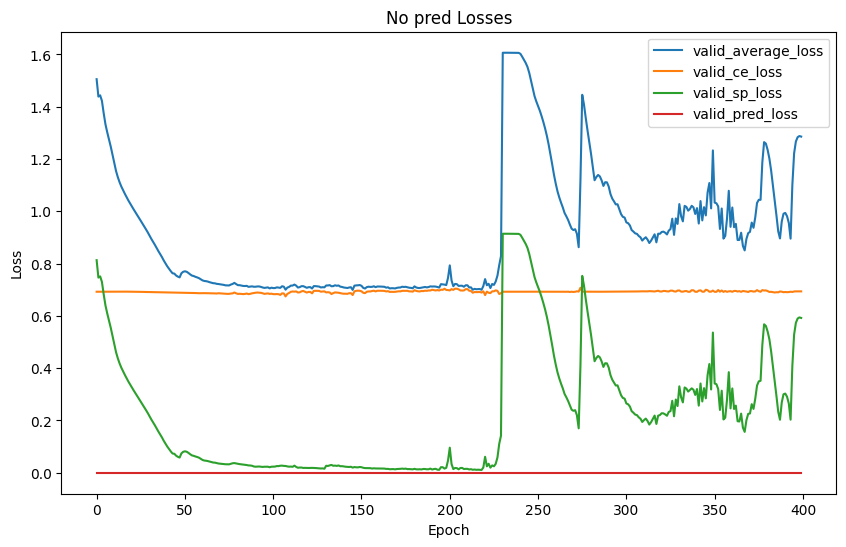

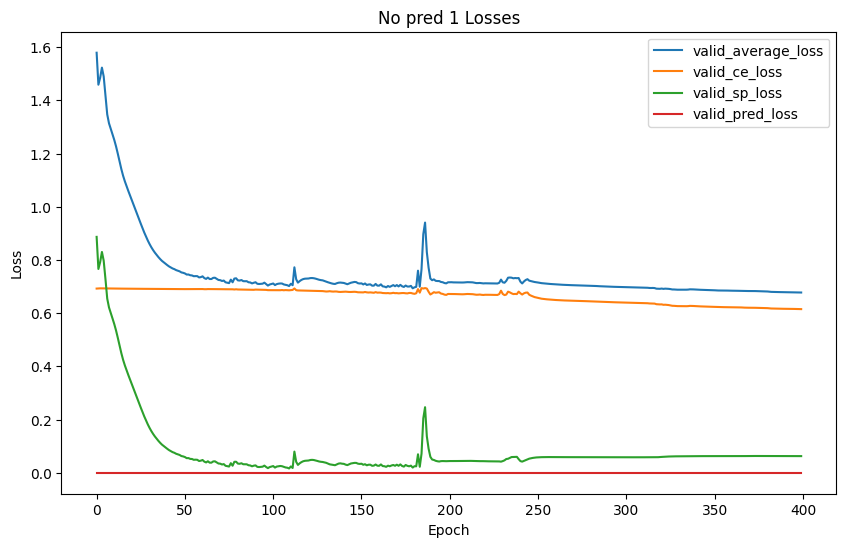

In [17]:
import matplotlib.pyplot as plt

# Extract the dataframes from results_slow
# train_results, val_results, test_results = no_sp_result
# _, all_results, _ = all_losses_result
# _, no_pred_results, _ = no_pred_result
# _, no_sp_results, _ = no_sp_result
# _, ce_results, _ = only_ce_result

no_pred_results = pd.read_csv("/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_pred/val_results.csv")
no_pred_results1 = pd.read_csv("/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/no_pred_1/val_results.csv")

# Function to plot loss values from a dataframe
def plot_loss_values(df, title):
    loss_columns = [col for col in df.columns if "loss" in col]
    df[loss_columns].plot(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()
    # plt.savefig(f"{title}.png")

# Plot the loss values for each dataframe
plot_loss_values(no_pred_results, "No pred Losses")
plot_loss_values(no_pred_results1, "No pred 1 Losses")


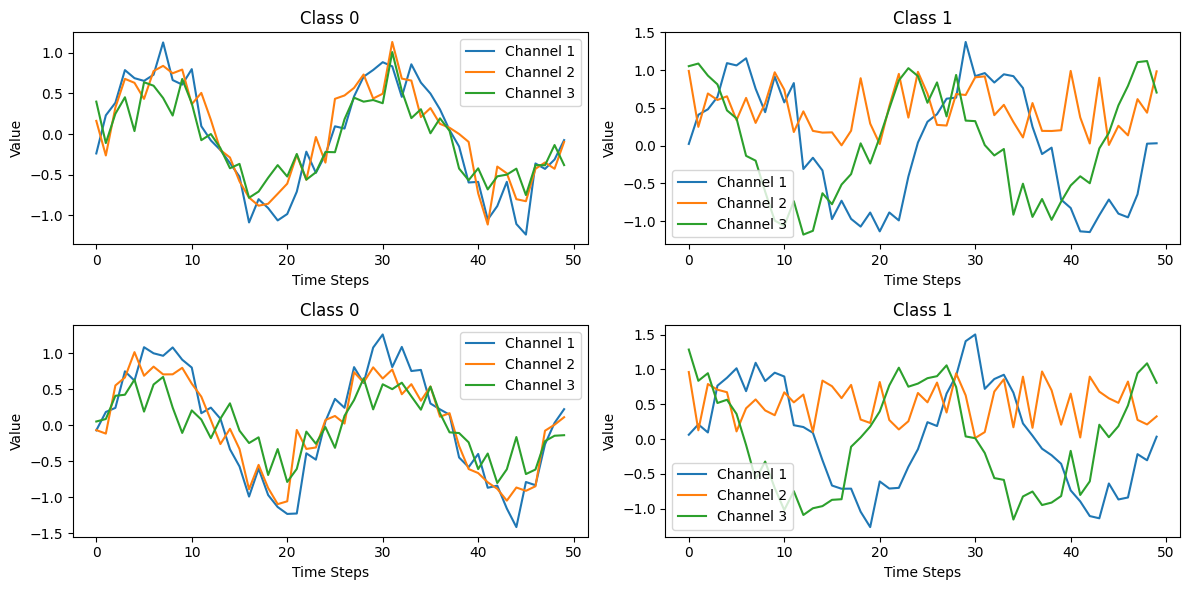

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_multimodal_time_series(n_samples, seq_length, n_channels, noise_level=0.2):
    """
    Generate multimodal time series data with distinct correlation profiles for two classes.

    Args:
        n_samples (int): Number of time series samples to generate.
        seq_length (int): Length of each time series sequence.
        n_channels (int): Number of channels (modalities) in each sequence.
        noise_level (float): Standard deviation of added noise.

    Returns:
        data (numpy.ndarray): Multimodal time series data of shape (n_samples, seq_length, n_channels).
        labels (numpy.ndarray): Corresponding labels of shape (n_samples,).
    """
    data = []
    labels = []

    for i in range(n_samples):
        if i % 2 == 0:
            # Class 1: Strong correlation
            base_signal = np.sin(np.linspace(0, 4 * np.pi, seq_length))  # Base oscillatory signal
            series = np.array([
                base_signal + noise_level * np.random.randn(seq_length),  # Channel 1
                0.8 * base_signal + noise_level * np.random.randn(seq_length),  # Channel 2 (scaled version)
                0.5 * base_signal + 0.2 * np.random.randn(seq_length)  # Channel 3 (weaker scaling)
            ]).T  # Transpose to shape (seq_length, n_channels)
            labels.append(0)
        else:
            # Class 2: Weak correlation
            channel_1 = np.sin(np.linspace(0, 4 * np.pi, seq_length)) + noise_level * np.random.randn(seq_length)
            channel_2 = np.random.rand(seq_length)  # Random independent signal
            channel_3 = np.cos(np.linspace(0, 4 * np.pi, seq_length)) + noise_level * np.random.randn(seq_length)
            series = np.stack([channel_1, channel_2, channel_3], axis=1)  # Stack channels
            labels.append(1)

        data.append(series)

    return np.array(data), np.array(labels)

# Parameters
n_samples = 100  # Number of samples
seq_length = 50  # Length of each sequence
n_channels = 3  # Number of channels (modalities)
noise_level = 0.2  # Level of noise added to the sequences

# Generate the data
data, labels = generate_multimodal_time_series(n_samples, seq_length, n_channels, noise_level)

# Visualize a few examples
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    for ch in range(n_channels):
        plt.plot(data[i, :, ch], label=f"Channel {ch+1}")
    plt.title(f"Class {labels[i]}")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
plt.tight_layout()
plt.show()

# run FBIRN sex

In [18]:
fbirn_data, fbirn_labels = load_fbirn_main_sex()
fbirn_hold_data, fbirn_hold_labels = load_fbirn_holdout_sex()
dataloaders, hold_data, hold_labels = prepare_dataloaders(
    fbirn_data,
    fbirn_labels,
    k=0,
    hold_data=fbirn_hold_data,
    hold_labels=fbirn_hold_labels
)

In [41]:
from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 53
    
# model = glassDBN(model_cfg).to(device)
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

results_sex = run_experiment(50, model, dataloaders, hold_data, optimizer, save_path=f"{Logs_Root}fbirn_sex_1")

# file_list=$(for i in {0..49}; do [[ -f "fbirn_sex_${i}.png" ]] && echo "fbirn_sex_${i}.png"; done | sort -V)
# convert -delay 20 -loop 0 $file_list _fbirn_sex_0.gif

# file_list=$(for i in {0..49}; do [[ -f "fbirn_sex_1_${i}.png" ]] && echo "fbirn_sex_1_${i}.png"; done | sort -V)
# convert -delay 20 -loop 0 $file_list _fbirn_sex_1.gif

100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


In [19]:
# looking closer at the training

from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 53

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/fast_learning_sex/matrix"
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
results_fast = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath)

savepath = f"/data/users2/ppopov1/glass_proj/assets/test_logs/model_rewrite/slow_learning_sex/matrix"
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
results_slow = run_experiment(400, model, dataloaders, hold_data, optimizer, save_path=savepath)

# file_list=$(for i in {0..399}; do [[ -f "fast_learning_sex/matrix_${i}.png" ]] && echo "fast_learning_sex/matrix_${i}.png"; done | sort -V)
# convert -delay 10 -loop 1 $file_list _fast_learning_sex.gif

# file_list=$(for i in {0..399}; do [[ -f "slow_learning_sex/matrix_${i}.png" ]] && echo "slow_learning_sex/matrix_${i}.png"; done | sort -V)
# convert -delay 10 -loop 1 $file_list _slow_learning_sex.gif

100%|██████████| 400/400 [11:32<00:00,  1.73s/it]


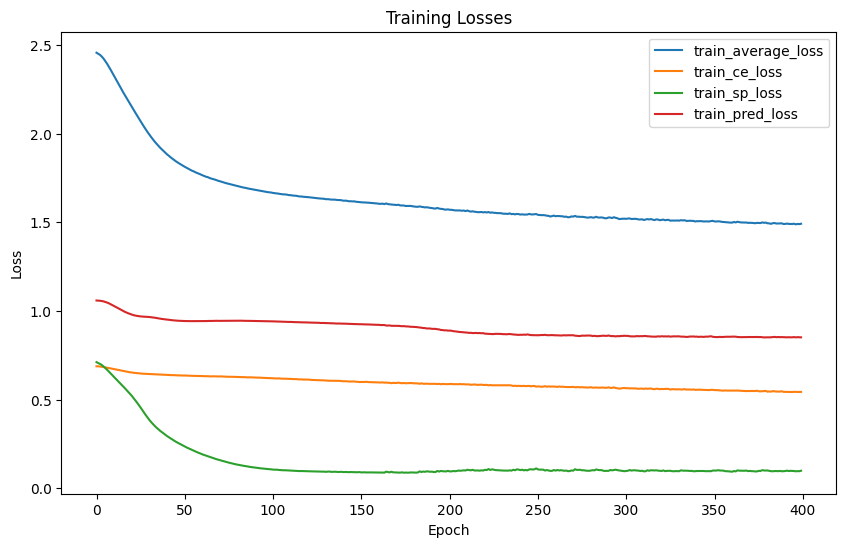

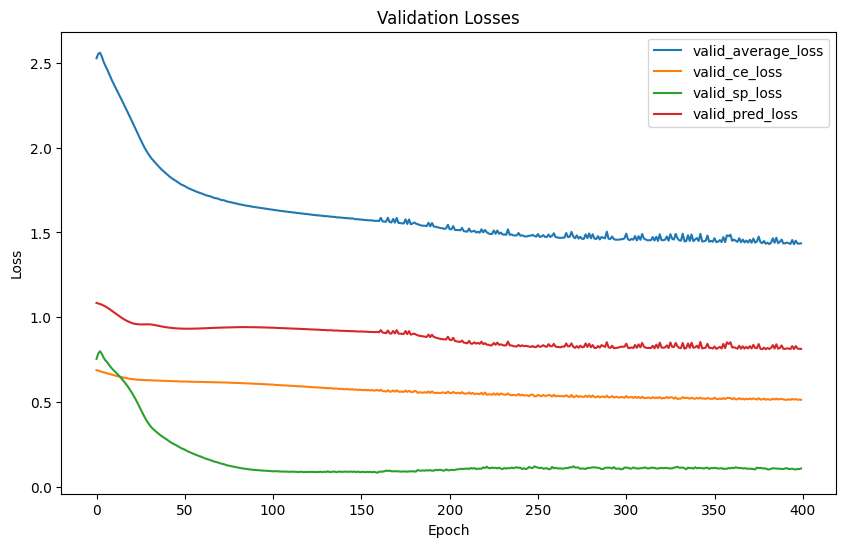

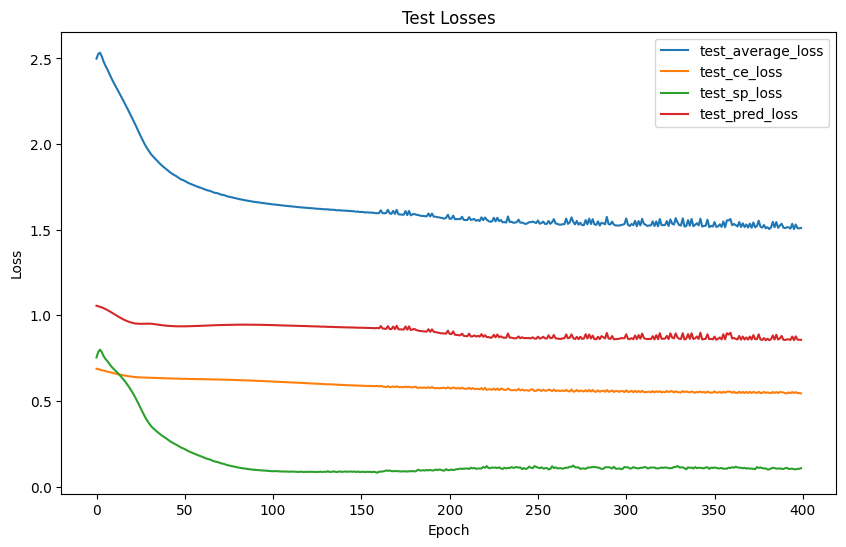

In [22]:
import matplotlib.pyplot as plt

# Extract the dataframes from results_slow
train_results, val_results, test_results = results_slow

# Function to plot loss values from a dataframe
def plot_loss_values(df, title):
    loss_columns = [col for col in df.columns if "loss" in col]
    df[loss_columns].plot(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()
    # plt.savefig(f"{title}.png")

# Plot the loss values for each dataframe
plot_loss_values(train_results, "Training Losses")
plot_loss_values(val_results, "Validation Losses")
plot_loss_values(test_results, "Test Losses")

# file_list=$(for i in {0..150}; do [[ -f "slow_learning_sex/matrix_${i}.png" ]] && echo "slow_learning_sex/matrix_${i}.png"; done | sort -V)
# convert -delay 10 -loop 1 $file_list slow_learning_sex_first_150.gif
# file_list=$(for i in {150..300}; do [[ -f "slow_learning_sex/matrix_${i}.png" ]] && echo "slow_learning_sex/matrix_${i}.png"; done | sort -V)
# convert -delay 10 -loop 1 $file_list slow_learning_sex_second_150.gif


# run FBIRN Schaefer

In [44]:
fbirn_data, fbirn_labels = load_fbirn_sch()
fbirn_hold_data, fbirn_hold_labels = fbirn_data[300:], fbirn_labels[300:]
fbirn_data, fbirn_labels = fbirn_data[:300], fbirn_labels[:300]
dataloaders, hold_data, hold_labels = prepare_dataloaders(
    fbirn_data,
    fbirn_labels,
    k=0,
    hold_data=fbirn_hold_data,
    hold_labels=fbirn_hold_labels,
    batch_size=16
)

In [45]:
from omegaconf import open_dict
with open_dict(model_cfg):
    model_cfg.input_size = 200
    
# model = glassDBN(model_cfg).to(device)
model = BrainDynaMo(model_cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

results_schaefer = run_experiment(50, model, dataloaders, hold_data, optimizer, save_path=f"{Logs_Root}fbirn_sch_1")

# file_list=$(for i in {0..49}; do [[ -f "fbirn_sch_${i}.png" ]] && echo "fbirn_sch_${i}.png"; done | sort -V)
# convert -delay 20 -loop 0 $file_list _fbirn_sch_0.gif

# file_list=$(for i in {0..49}; do [[ -f "fbirn_sch_1_${i}.png" ]] && echo "fbirn_sch_1_${i}.png"; done | sort -V)
# convert -delay 20 -loop 0 $file_list _fbirn_sch_1.gif

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:54<00:00,  5.89s/it]


# analyze framework experiment result

In [7]:
import pandas as pd

models = ["BrainDynaMo", "DBNglassFIX", "mlp"]
datasets = ["fbirn_main", "fbirn_main_sex"]
results = {}
for model in models:
    results[model] = {}
    for dataset in datasets:
        path = f"/data/users2/ppopov1/glass_proj/assets/logs/_7_holdout-exp-{model}-{dataset}/runs.csv"
        results[model][dataset] = pd.read_csv(path)

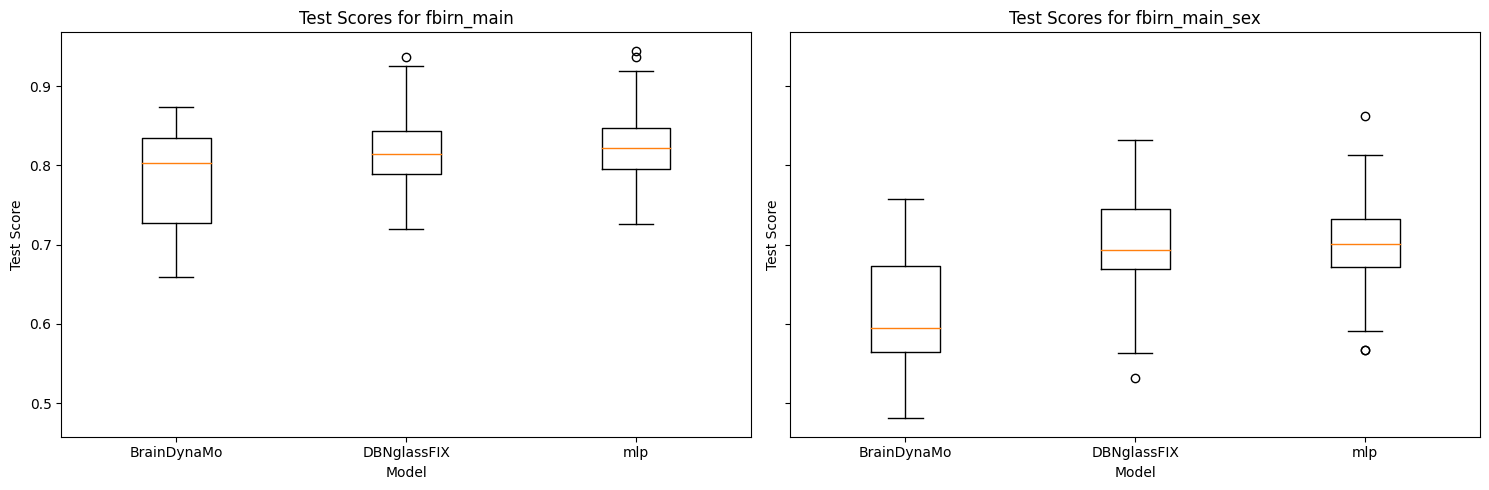

In [9]:
import matplotlib.pyplot as plt

# Prepare data for plotting
data_to_plot = {}
for dataset in datasets:
    data_to_plot[dataset] = []
    for model in models:
        data_to_plot[dataset].append(results[model][dataset]["test_score"])

# Plot boxplots
fig, axes = plt.subplots(1, len(datasets), figsize=(15, 5), sharey=True)
if len(datasets) == 1:
    axes = [axes]

for i, dataset in enumerate(datasets):
    axes[i].boxplot(data_to_plot[dataset], labels=models)
    axes[i].set_title(f"Test Scores for {dataset}")
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel("Test Score")

plt.tight_layout()
plt.show()

In [21]:
import torch
def load_torch_arrays(paths):
    arrays = []
    for path in paths:
        array = torch.load(path)
        arrays.append(array)
    return arrays

paths = []
paths_sex = []
for k in range(4):
    for trial in range(10):
        paths.append(f"/data/users2/ppopov1/glass_proj/assets/logs/_7_holdout-exp-BrainDynaMo-fbirn_main/k_{k:02d}/trial_{trial:04d}/data/fbirn_holdout_time_logits.pt")
        paths_sex.append(f"/data/users2/ppopov1/glass_proj/assets/logs/_7_holdout-exp-BrainDynaMo-fbirn_main_sex/k_{k:02d}/trial_{trial:04d}/data/fbirn_holdout_sex_time_logits.pt")
        # paths.append(f"/data/users2/ppopov1/glass_proj/assets/logs/_7_holdout-exp-BrainDynaMo-fbirn_main/k_{k:02d}/trial_{trial:04d}/data/fbirn_holdout_FNCs.pt")
        # paths_sex.append(f"/data/users2/ppopov1/glass_proj/assets/logs/_7_holdout-exp-BrainDynaMo-fbirn_main_sex/k_{k:02d}/trial_{trial:04d}/data/fbirn_holdout_sex_FNCs.pt")

arrays = load_torch_arrays(paths)
arrays_sex = load_torch_arrays(paths_sex)

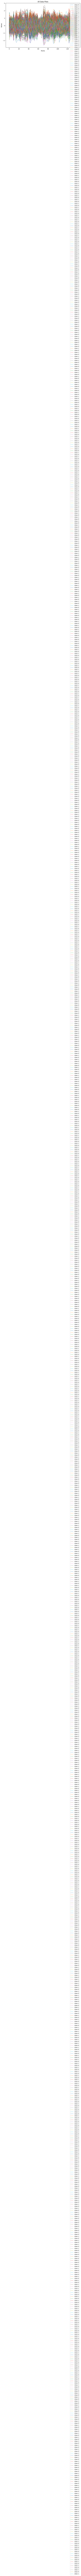

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Plot all the lines
plt.figure(figsize=(10, 6))
for i, array in enumerate(arrays):
    for j in range(array.shape[0]):
        plt.plot(array[j, :, 0].cpu().numpy(), label=f'class 0', alpha=0.5)
        plt.plot(array[j, :, 1].cpu().numpy(), label=f'class 1', alpha=0.5)

plt.xlabel('Points')
plt.ylabel('Values')
plt.title('All Data Plots')
plt.legend()
plt.show()


In [20]:
for i, matrices in enumerate(arrays_sex):
    plot_matrices(matrices, f"/data/users2/ppopov1/glass_proj/assets/test_logs/lots_of_matrices/sex_{i}.png", n_samples=1)
# for i, matrices in enumerate(arrays):
#     plot_matrices(matrices, f"/data/users2/ppopov1/glass_proj/assets/test_logs/lots_of_matrices/SZ_{i}.png", n_samples=1)